In [ ]:
import time
start_time = time.time()

In [ ]:
import tensorflow as tf
import os
import cv2
import numpy as np

In [ ]:
import shutil
shutil.move('/content/kaggle.json', '/root/.kaggle/kaggle.json')
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d kunalmadan/vehicle-multi-classification

 98% 79.0M/80.3M [00:06<00:00, 18.0MB/s]
100% 80.3M/80.3M [00:06<00:00, 12.0MB/s]


In [ ]:
from zipfile import ZipFile

zip_file_path = '/content/vehicle-multi-classification.zip'

with ZipFile(zip_file_path, 'r') as zip:
    zip.extractall()

In [ ]:
data_dir = 'data'

In [ ]:
extensions = ('.png', '.jpg', '.jpeg')

In [ ]:
valid_images = []

for image_class in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, image_class)
    if not os.path.isdir(class_dir):
        continue
    for image in os.listdir(class_dir):
        if image.lower().endswith(extensions):
            image_path = os.path.join(class_dir, image)
            img = cv2.imread(image_path)

            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (224, 224))

            valid_images.append((img, image_class))
        else:
            print('Issue with image {}'.format(image_path))

Issue with image data/car/images143.jpg
Issue with image data/car/images183.jpg
Issue with image data/car/images177.jpg
Issue with image data/car/images55.jpg
Issue with image data/car/images161.jpg
Issue with image data/car/images30.jpg
Issue with image data/car/images62.jpg
Issue with image data/car/images49.jpg
Issue with image data/car/images19.jpg
Issue with image data/car/Hyderabad-entrepreneur-buys-most-expensive-car.jpeg
Issue with image data/car/images86.jpg
Issue with image data/car/images103.jpg
Issue with image data/car/images123.jpg
Issue with image data/car/images274.jpg
Issue with image data/car/images240.jpg
Issue with image data/car/images218.jpg
Issue with image data/car/images85.jpg


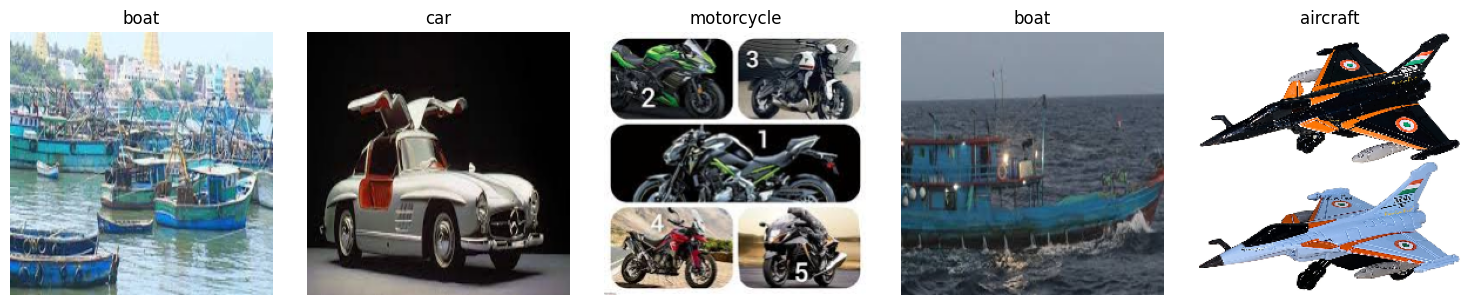

In [ ]:
import matplotlib.pyplot as plt
import random

random_images = random.sample(valid_images, 5)
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, (image, image_class) in enumerate(random_images):
    axes[i].imshow(image)
    axes[i].set_title(image_class)
    axes[i].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
files = os.listdir(data_dir)
print(files)

['motorcycle', 'boat', 'bus', 'aircraft', 'car', 'truck']


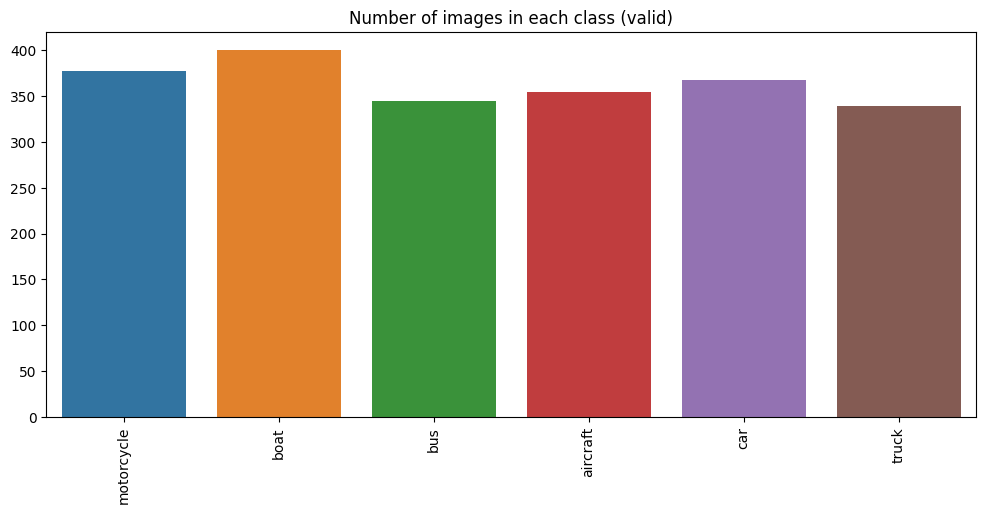

In [ ]:
import seaborn as sns

classes = []
num_imgs = []

for _, image_class in valid_images:
    if image_class not in classes:
        classes.append(image_class)
        num_imgs.append(1)
    else:
        index = classes.index(image_class)
        num_imgs[index] += 1

plt.figure(figsize=(12, 5))
sns.barplot(x=classes, y=num_imgs)
plt.title('Number of images in each class (valid)')
plt.xticks(rotation=90)
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split

train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

train_data, remaining_data = train_test_split(valid_images, test_size=1 - train_ratio, random_state=42)
val_data, test_data = train_test_split(remaining_data, test_size=test_ratio / (val_ratio + test_ratio), random_state=42)

In [ ]:
print("Training set size:", len(train_data))
print("Validation set size:", len(val_data))
print("Test set size:", len(test_data))

Training set size: 1527
Validation set size: 436
Test set size: 219


In [ ]:
train_images = np.array([data[0] for data in train_data])
train_labels = np.array([data[1] for data in train_data])
val_images = np.array([data[0] for data in val_data])
val_labels = np.array([data[1] for data in val_data])
test_images = np.array([data[0] for data in test_data])
test_labels = np.array([data[1] for data in test_data])

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
label_map = {
    "aircraft": 0,
    "boat": 1,
    "bus": 2,
    "car": 3,
    "motorcycle": 4,
    "truck": 5
}

In [ ]:
train_labels = [label_map[class_name] for (_, class_name) in train_data]
val_labels = [label_map[class_name] for (_, class_name) in val_data]
test_labels = [label_map[class_name] for (_, class_name) in test_data]

In [ ]:
from tensorflow.keras.utils import to_categorical
num_classes = len(classes)

train_labels = to_categorical(train_labels, num_classes)
val_labels = to_categorical(val_labels, num_classes)
test_labels = to_categorical(test_labels, num_classes)

In [ ]:
batch_size = 32
num_classes = len(classes)

In [ ]:
train_generator = train_datagen.flow(
    train_images,
    train_labels,
    batch_size=batch_size,
    shuffle=True
)

val_generator = val_datagen.flow(
    val_images,
    val_labels,
    batch_size=batch_size
)

test_generator = test_datagen.flow(
    test_images,
    test_labels,
    batch_size=batch_size
)

In [ ]:
model_names = []
model_accuracies = []
model_losses = []
models = []

# Local Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model1 = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.5),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.25),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

In [ ]:
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model1.fit(train_generator, epochs=10, validation_data=val_generator)

Epoch 1/10
48/48 [==============================] - 33s 423ms/step - loss: 1.9779 - accuracy: 0.1899 - val_loss: 1.7891 - val_accuracy: 0.2087
Epoch 2/10
48/48 [==============================] - 19s 402ms/step - loss: 1.7552 - accuracy: 0.2377 - val_loss: 1.7281 - val_accuracy: 0.2225
Epoch 3/10
48/48 [==============================] - 19s 384ms/step - loss: 1.6814 - accuracy: 0.2482 - val_loss: 1.6179 - val_accuracy: 0.3509
Epoch 4/10
48/48 [==============================] - 19s 395ms/step - loss: 1.6276 - accuracy: 0.3170 - val_loss: 1.6142 - val_accuracy: 0.3073
Epoch 5/10
48/48 [==============================] - 19s 395ms/step - loss: 1.5627 - accuracy: 0.3491 - val_loss: 1.5362 - val_accuracy: 0.3394
Epoch 6/10
48/48 [==============================] - 19s 384ms/step - loss: 1.6399 - accuracy: 0.2862 - val_loss: 1.5974 - val_accuracy: 0.2982
Epoch 7/10
48/48 [==============================] - 20s 410ms/step - loss: 1.5984 - accuracy: 0.3353 - val_loss: 1.4610 - val_accuracy: 0.4404

In [ ]:
test_loss1, test_accuracy1 = model1.evaluate(test_generator)
print('Test accuracy:', test_accuracy1)
model_names.append('Local Model')
model_accuracies.append(test_accuracy1)
model_losses.append(test_loss1)
models.append((model1,history))

7/7 [==============================] - 1s 148ms/step - loss: 1.4291 - accuracy: 0.4612
Test accuracy: 0.4611872136592865


# EfficientNetV2B0 Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

base_model = EfficientNetV2B0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

last_output = base_model.output

x = GlobalAveragePooling2D()(last_output)
x = Dense(512, activation='relu')(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(num_classes, activation='softmax')(x)

model2 = Model(inputs=base_model.input, outputs=outputs)

model2.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model2.fit(train_generator, epochs=10, validation_data=val_generator)

24274472/24274472 [==============================] - 2s 0us/step
Epoch 1/10
48/48 [==============================] - 28s 409ms/step - loss: 1.8026 - accuracy: 0.1781 - val_loss: 1.7884 - val_accuracy: 0.1927
Epoch 2/10
48/48 [==============================] - 18s 375ms/step - loss: 1.7958 - accuracy: 0.1971 - val_loss: 1.8210 - val_accuracy: 0.1284
Epoch 3/10
48/48 [==============================] - 17s 349ms/step - loss: 1.7981 - accuracy: 0.1650 - val_loss: 1.7840 - val_accuracy: 0.2179
Epoch 4/10
48/48 [==============================] - 18s 378ms/step - loss: 1.7921 - accuracy: 0.1807 - val_loss: 1.7815 - val_accuracy: 0.2821
Epoch 5/10
48/48 [==============================] - 17s 348ms/step - loss: 1.7921 - accuracy: 0.1722 - val_loss: 1.7806 - val_accuracy: 0.2156
Epoch 6/10
48/48 [==============================] - 18s 372ms/step - loss: 1.7903 - accuracy: 0.1866 - val_loss: 1.7891 - val_accuracy: 0.1422
Epoch 7/10
48/48 [==============================] - 17s 349ms/step - loss: 1.

In [ ]:
test_loss2, test_accuracy2 = model2.evaluate(test_generator)
print('Test accuracy:', test_accuracy2)
model_names.append('EfficientNetV2B0 Model')
model_accuracies.append(test_accuracy2)
model_losses.append(test_loss2)
models.append((model2,history))

7/7 [==============================] - 1s 174ms/step - loss: 1.7743 - accuracy: 0.2466
Test accuracy: 0.24657534062862396


# MobileNet Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

model3 = Model(inputs=base_model.input, outputs=predictions)

model3.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model3.fit(train_generator, epochs=10, validation_data=val_generator)

17225924/17225924 [==============================] - 2s 0us/step
Epoch 1/10
48/48 [==============================] - 20s 374ms/step - loss: 0.6842 - accuracy: 0.7551 - val_loss: 0.2053 - val_accuracy: 0.9335
Epoch 2/10
48/48 [==============================] - 16s 341ms/step - loss: 0.2672 - accuracy: 0.9070 - val_loss: 0.1800 - val_accuracy: 0.9243
Epoch 3/10
48/48 [==============================] - 16s 340ms/step - loss: 0.2111 - accuracy: 0.9332 - val_loss: 0.2040 - val_accuracy: 0.9151
Epoch 4/10
48/48 [==============================] - 17s 356ms/step - loss: 0.2286 - accuracy: 0.9234 - val_loss: 0.1708 - val_accuracy: 0.9335
Epoch 5/10
48/48 [==============================] - 16s 341ms/step - loss: 0.1858 - accuracy: 0.9299 - val_loss: 0.2002 - val_accuracy: 0.9335
Epoch 6/10
48/48 [==============================] - 16s 337ms/step - loss: 0.1517 - accuracy: 0.9443 - val_loss: 0.1995 - val_accuracy: 0.9220
Epoch 7/10
48/48 [==============================] - 17s 356ms/step - loss: 0.

In [ ]:
test_loss3, test_accuracy3 = model3.evaluate(test_generator)
print('Test accuracy:', test_accuracy3)
model_names.append('MobileNet Model')
model_accuracies.append(test_accuracy3)
model_losses.append(test_loss3)
models.append((model3,history))

7/7 [==============================] - 1s 84ms/step - loss: 0.1911 - accuracy: 0.9178
Test accuracy: 0.9178082346916199


# MobileNetV2

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

last_output = base_model.output

x = GlobalAveragePooling2D()(last_output)
x = Dense(512, activation='relu')(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(num_classes, activation='softmax')(x)

model4 = Model(inputs=base_model.input, outputs=outputs)

model4.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model4.fit(train_generator, epochs=10, validation_data=val_generator)

9406464/9406464 [==============================] - 2s 0us/step
Epoch 1/10
48/48 [==============================] - 22s 372ms/step - loss: 1.0751 - accuracy: 0.6608 - val_loss: 0.4542 - val_accuracy: 0.9014
Epoch 2/10
48/48 [==============================] - 16s 339ms/step - loss: 0.4535 - accuracy: 0.8553 - val_loss: 0.2587 - val_accuracy: 0.9266
Epoch 3/10
48/48 [==============================] - 16s 337ms/step - loss: 0.3397 - accuracy: 0.8913 - val_loss: 0.2123 - val_accuracy: 0.9404
Epoch 4/10
48/48 [==============================] - 16s 339ms/step - loss: 0.2809 - accuracy: 0.9155 - val_loss: 0.2243 - val_accuracy: 0.9174
Epoch 5/10
48/48 [==============================] - 17s 360ms/step - loss: 0.2610 - accuracy: 0.9096 - val_loss: 0.1908 - val_accuracy: 0.9335
Epoch 6/10
48/48 [==============================] - 17s 345ms/step - loss: 0.2248 - accuracy: 0.9208 - val_loss: 0.2083 - val_accuracy: 0.9243
Epoch 7/10
48/48 [==============================] - 17s 345ms/step - loss: 0.21

In [ ]:
test_loss4, test_accuracy4 = model4.evaluate(test_generator)
print('Test accuracy:', test_accuracy4)
model_names.append('MobileNetV2 Model')
model_accuracies.append(test_accuracy4)
model_losses.append(test_loss4)
models.append((model4,history))

7/7 [==============================] - 1s 110ms/step - loss: 0.1597 - accuracy: 0.9543
Test accuracy: 0.9543378949165344


# VGG16 Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

last_output = base_model.output

x = GlobalAveragePooling2D()(last_output)
x = Dense(512, activation='relu')(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(num_classes, activation='softmax')(x)

model5 = Model(inputs=base_model.input, outputs=outputs)

model5.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model5.fit(train_generator, epochs=10, validation_data=val_generator)

58889256/58889256 [==============================] - 4s 0us/step
Epoch 1/10
48/48 [==============================] - 31s 538ms/step - loss: 1.7175 - accuracy: 0.3451 - val_loss: 1.6025 - val_accuracy: 0.5711
Epoch 2/10
48/48 [==============================] - 19s 404ms/step - loss: 1.5479 - accuracy: 0.5743 - val_loss: 1.4076 - val_accuracy: 0.6606
Epoch 3/10
48/48 [==============================] - 19s 385ms/step - loss: 1.3875 - accuracy: 0.6097 - val_loss: 1.2311 - val_accuracy: 0.6881
Epoch 4/10
48/48 [==============================] - 19s 403ms/step - loss: 1.2440 - accuracy: 0.6582 - val_loss: 1.0691 - val_accuracy: 0.7087
Epoch 5/10
48/48 [==============================] - 19s 388ms/step - loss: 1.1234 - accuracy: 0.6811 - val_loss: 0.9606 - val_accuracy: 0.7179
Epoch 6/10
48/48 [==============================] - 19s 390ms/step - loss: 1.0161 - accuracy: 0.7099 - val_loss: 0.8620 - val_accuracy: 0.7683
Epoch 7/10
48/48 [==============================] - 19s 388ms/step - loss: 0.

In [ ]:
test_loss5, test_accuracy5 = model5.evaluate(test_generator)
print('Test accuracy:', test_accuracy5)
model_names.append('VGG16 Model')
model_accuracies.append(test_accuracy5)
model_losses.append(test_loss5)
models.append((model5,history))

7/7 [==============================] - 5s 733ms/step - loss: 0.6522 - accuracy: 0.7900
Test accuracy: 0.7899543642997742


# InceptionV3 Model

In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

last_output = base_model.output

x = GlobalAveragePooling2D()(last_output)
x = Dense(512, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(6, activation='softmax')(x)

model6 = Model(inputs=base_model.input, outputs=outputs)

model6.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model6.fit(train_generator,
                    epochs=10,
                    validation_data=val_generator)

87910968/87910968 [==============================] - 5s 0us/step
Epoch 1/10
48/48 [==============================] - 28s 443ms/step - loss: 1.2505 - accuracy: 0.5455 - val_loss: 0.4014 - val_accuracy: 0.9197
Epoch 2/10
48/48 [==============================] - 18s 362ms/step - loss: 0.6215 - accuracy: 0.7937 - val_loss: 0.2628 - val_accuracy: 0.9358
Epoch 3/10
48/48 [==============================] - 17s 361ms/step - loss: 0.5105 - accuracy: 0.8304 - val_loss: 0.2194 - val_accuracy: 0.9381
Epoch 4/10
48/48 [==============================] - 18s 381ms/step - loss: 0.4512 - accuracy: 0.8494 - val_loss: 0.2151 - val_accuracy: 0.9266
Epoch 5/10
48/48 [==============================] - 17s 360ms/step - loss: 0.4217 - accuracy: 0.8448 - val_loss: 0.2207 - val_accuracy: 0.9266
Epoch 6/10
48/48 [==============================] - 18s 381ms/step - loss: 0.3925 - accuracy: 0.8664 - val_loss: 0.2060 - val_accuracy: 0.9427
Epoch 7/10
48/48 [==============================] - 18s 365ms/step - loss: 0.

In [ ]:
test_loss6, test_accuracy6 = model6.evaluate(test_generator)
print('Test accuracy:', test_accuracy6)
model_names.append('InceptionV3 Model')
model_accuracies.append(test_accuracy6)
model_losses.append(test_loss6)
models.append((model6,history))

7/7 [==============================] - 2s 312ms/step - loss: 0.2508 - accuracy: 0.8995
Test accuracy: 0.8995434045791626


In [ ]:
from tabulate import tabulate

table_data = [[model_names[i], model_accuracies[i],model_losses[i]] for i in range(len(model_names))]
headers = ["Model", "Accuracy", "Loss"]

table = tabulate(table_data, headers, tablefmt="grid")
print(table)

+------------------------+------------+----------+
| Model                  |   Accuracy |     Loss |
+========================+============+==========+
| Local Model            |   0.461187 | 1.42911  |
+------------------------+------------+----------+
| EfficientNetV2B0 Model |   0.246575 | 1.77426  |
+------------------------+------------+----------+
| MobileNet Model        |   0.917808 | 0.191116 |
+------------------------+------------+----------+
| MobileNetV2 Model      |   0.954338 | 0.1597   |
+------------------------+------------+----------+
| VGG16 Model            |   0.789954 | 0.652238 |
+------------------------+------------+----------+
| InceptionV3 Model      |   0.899543 | 0.250821 |
+------------------------+------------+----------+


In [ ]:
best_accuracy = max(model_accuracies)
best_model_index = model_accuracies.index(best_accuracy)
best_model_name = model_names[best_model_index]
best_model = models[best_model_index][0]
history = models[best_model_index][1]

print("Best Model: {}, Accuracy: {:.3f}%".format(best_model_name, best_accuracy*100))

Best Model: MobileNetV2 Model, Accuracy: 95.434%


In [ ]:
from sklearn.metrics import classification_report

class_names = {v: k for k, v in label_map.items()}

test_pred_labels = best_model.predict(test_generator)
test_pred_labels = np.argmax(test_pred_labels,axis=1)
test_pred_class_names = [class_names[i] for i in test_pred_labels]
true_class_names = [class_names[i] for i in np.argmax(test_labels, axis=1)]

report = classification_report(true_class_names, test_pred_class_names)

print("Classification Report:")
print(report)

7/7 [==============================] - 1s 37ms/step
Classification Report:
              precision    recall  f1-score   support

    aircraft       0.27      0.28      0.27        40
        boat       0.22      0.21      0.22        42
         bus       0.13      0.13      0.13        38
         car       0.16      0.18      0.17        34
  motorcycle       0.15      0.15      0.15        39
       truck       0.05      0.04      0.04        26

    accuracy                           0.17       219
   macro avg       0.16      0.16      0.16       219
weighted avg       0.17      0.17      0.17       219



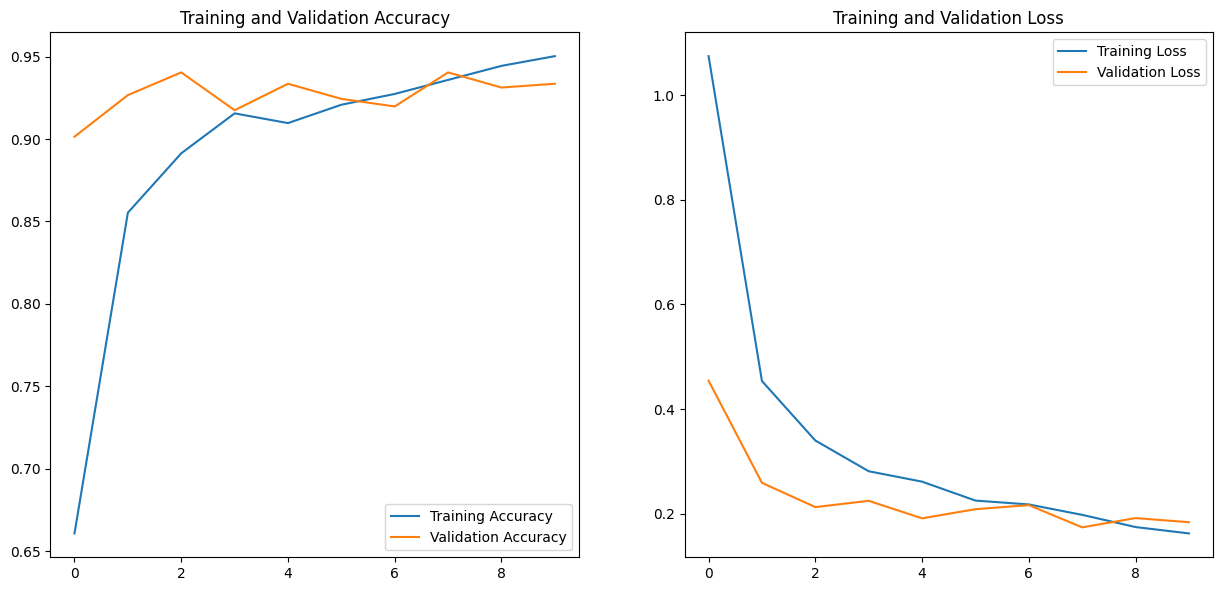

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
end_time = time.time()
total_time = end_time - start_time
print("Total execution time:", total_time, "seconds")

Total execution time: 1220.931926727295 seconds


In [ ]:
#from PIL import Image
#
#img = Image.open('/content/test1.jpg').resize((224, 224))
#img.show()
#
#img_array = np.array(img)
#img_array = img_array / 255.0
#img_array = np.expand_dims(img_array, axis=0)

#preds = best_model.predict(img_array)
#class_idx = np.argmax(preds)
#predicted_class_name = class_names[class_idx]

#print('Predicted label:', predicted_class_name)

FileNotFoundError: ignored

In [ ]:
#from PIL import Image
#
#img = Image.open('/content/test2.jpeg').resize((224, 224))
#img.show()

#img_array = np.array(img)
#img_array = img_array / 255.0
#img_array = np.expand_dims(img_array, axis=0)

#preds = best_model.predict(img_array)
#class_idx = np.argmax(preds)
#predicted_class_name = class_names[class_idx]

#print('Predicted label:', predicted_class_name)